In [23]:
import numpy as np
import pandas as pd

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize

import fasttext as ft

from tqdm import trange

# Настройки

In [24]:
# Параметры обучения
EPOCHS = 30

# Параметры загрузчиков
BATCH_SIZE  = 64
NUM_WORKERS = 0

# Параметры оптимизатора
WEIGTH_DECAY = 5e-5
LR = 3e-3

# Параметры планировщика
PATIENCE  = 5
MIN_LR    = 1e-6
THRESHOLD = 1e-4

# Параметры LSTM
EMBED_DIM = 300
HIDDEN_DIM = 512
N_LAYERS = 2
DROP_PROB = 0.5
BIDIRECTIONAL = False

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Загрузка датасета

In [26]:
df = pd.read_csv("ner_dataset.csv",  encoding = 'unicode_escape')
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [27]:
df['Tag'].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [28]:
num_tag = len(df['Tag'].unique())

# Обработка датасета

In [29]:
enc_tag = LabelEncoder()

df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method = "ffill")
df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

sentences = df.groupby("Sentence #")["Word"].apply(list).values
tag = df.groupby("Sentence #")["Tag"].apply(list).values

C:\Users\Sanya\AppData\Local\Temp\ipykernel_29564\4076540538.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method = "ffill")


In [30]:
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [31]:
max_len = np.max(list(map(len, sentences)))

# Загрузка модели FastText

In [32]:
fasttext_model = ft.load_model("cc.en.300.bin")

# Создание датасета

In [33]:
class EntityDataset:
    def __init__(self, texts, tags, max_len):
        self.max_len = max_len

        self.texts = [[fasttext_model.get_word_vector(word) 
                     for word in np.pad(text, (0, max_len - len(text)), mode = 'constant', constant_values = '')] 
                     for text in texts]
        
        self.tags = [np.pad(tag, (0, max_len - len(tag)), mode = 'constant') for tag in tags]

        self.masks = [np.concatenate([np.ones(len(tag)), np.zeros(max_len - len(tag))])  
                      for tag in tags]
        
        self.texts = np.array(self.texts)
        self.tags  = np.array(self.tags)
        self.masks = np.array(self.masks)
        
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, id):
     
        return (torch.tensor(self.texts[id], dtype = torch.float32),
                torch.tensor(self.tags[id], dtype = torch.long),
                torch.tensor(self.masks[id], dtype = torch.long))

# Создание загрузчиков

In [34]:
X_train, X_test, y_train, y_test = train_test_split(sentences, tag, test_size = .2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5)

In [35]:
train_dataset = EntityDataset(texts = X_train, tags = y_train, max_len = max_len)
valid_dataset = EntityDataset(texts = X_val, tags = y_val, max_len = max_len)
test_dataset  = EntityDataset(texts = X_test, tags = y_test, max_len = max_len)

In [36]:
train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE, 
                          num_workers = NUM_WORKERS, 
                          shuffle = True, 
                          drop_last = True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE, 
                          num_workers = NUM_WORKERS,
                          shuffle = False, 
                          drop_last = True)

test_loader = DataLoader(test_dataset, 
                         batch_size = BATCH_SIZE, 
                         num_workers = NUM_WORKERS,
                         shuffle = False, 
                         drop_last = True)

# Подготовка лосс-функции

In [37]:
def get_loss(loss_fn, output, target, mask, cls_cnt):

    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, cls_cnt)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(loss_fn.ignore_index).type_as(target)
    )
    
    return loss_fn(active_logits, active_labels)

# Подготовка метрики

In [38]:
def get_stats(pred, target, mask):

    mask = mask.bool()
    pred = torch.masked_select(pred, mask)
    target = torch.masked_select(target, mask)

    correct = torch.sum(pred == target)
    total = len(pred)
    
    return correct, total

# Создание модели

In [39]:
class EntityModel(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5, bidirectional = False):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob,
                            batch_first = True, bidirectional = bidirectional)
        
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, embeds, hidden):

        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        num_directions = 2 if self.lstm.bidirectional else 1

        h_zeros = torch.zeros(self.n_layers * num_directions,
                              batch_size, 
                              self.hidden_dim,
                              dtype = torch.float32, 
                              device = device)
        
        c_zeros = torch.zeros(self.n_layers * num_directions,
                              batch_size, 
                              self.hidden_dim,
                              dtype = torch.float32, 
                              device=device)

        return (h_zeros, c_zeros)

# Тренировка

In [40]:
model = EntityModel(num_tag, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROP_PROB, BIDIRECTIONAL).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = LR, weight_decay = WEIGTH_DECAY)
schedule = ReduceLROnPlateau(optimizer, patience = PATIENCE, min_lr = MIN_LR, threshold = THRESHOLD)

In [41]:
# Значения функции потерь в течение обучения
train_losses = np.zeros(EPOCHS) 
val_losses   = np.zeros(EPOCHS)

# Значения accuracy в течение обучения
train_accs = np.zeros(EPOCHS) 
val_accs   = np.zeros(EPOCHS)

# Значения learning rate в течение обучения
lrs = []

for epoch in (pbar := trange(EPOCHS)):

    torch.save(model.state_dict(), 'weights.htp')
    best_acc = 0

    h = model.init_hidden(BATCH_SIZE)
    correct_sum, total_sum = 0, 0
    
    model = model.train()
        
    for inputs, labels, mask in train_loader:  

            h = tuple([e.data for e in h])

            inputs = inputs.to(device)
            labels = labels.to(device)
            mask  = mask.to(device)
            
            # Прямой проход
            model.zero_grad()
            outputs, h = model(inputs, h)
            loss = get_loss(criterion, outputs, labels.flatten(), mask.flatten(), num_tag)           
            train_losses[epoch] += loss.item()

            predicted = torch.argmax(outputs.data, dim = -1)

            correct, total = get_stats(predicted, labels.flatten(), mask.flatten())
            correct_sum += correct
            total_sum += total

            # Обратный проход и оптимизация
            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()
            
            lrs.append(optimizer.param_groups[0]["lr"])           

    train_accs[epoch] = 100 * correct_sum / total_sum
    train_losses[epoch] /= len(train_loader)  
    
    # Валидация
    with torch.no_grad():

        h = model.init_hidden(BATCH_SIZE)
        correct_sum, total_sum = 0, 0

        model = model.eval()

        for inputs, labels, mask in valid_loader:

            h = tuple([e.data for e in h])

            inputs = inputs.to(device)
            labels = labels.to(device)
            mask  = mask.to(device)

            # Прямой проход
            model.zero_grad()
            outputs, h = model(inputs, h)
            loss = get_loss(criterion, outputs, labels.flatten(), mask.flatten(), num_tag)           
            val_losses[epoch] += loss.item()

            predicted = torch.argmax(outputs.data, dim = -1)
                
            correct, total = get_stats(predicted, labels.flatten(), mask.flatten())
            correct_sum += correct
            total_sum += total

            val_accs[epoch] = 100 * correct_sum / total_sum
            val_losses[epoch] /= len(valid_loader)

        # Сохранение весов, если результат на текущей эпохе лучше
        if best_acc < val_accs[epoch]:
            best_acc = val_accs[epoch]
            torch.save(model.state_dict(), 'weights.htp')

    schedule.step(val_losses[epoch])

    pbar.set_description((f'Avg. train/valid loss: [{train_losses[epoch].item():.4f}/{val_losses[epoch].item():.4f}], ' 
                          f'train/valid accuracy: [{train_accs[epoch]:.2f}%/{val_accs[epoch]:.2f}%]'))
    
# Загрузка лучших весов
model.load_state_dict(torch.load('weights.htp'))

Avg. train/valid loss: [0.0332/0.0025], train/valid accuracy: [98.86%/96.18%]: 100%|██████████| 30/30 [09:23<00:00, 18.77s/it]


<All keys matched successfully>

# Графики

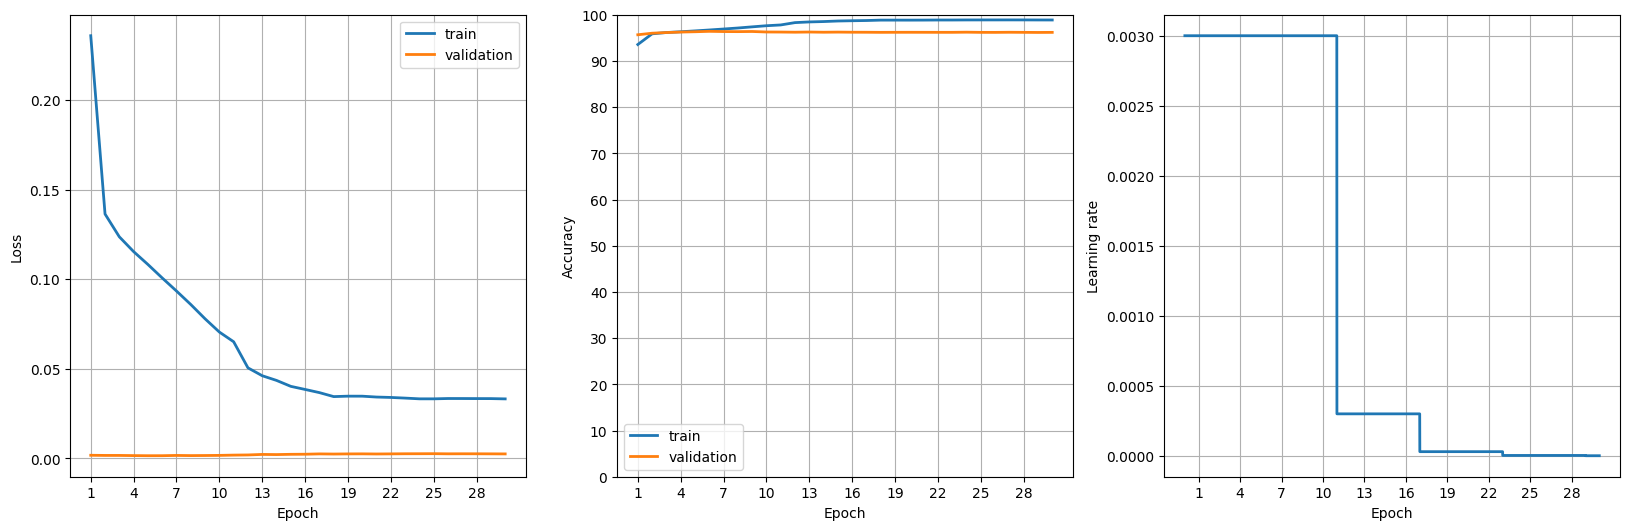

In [42]:
step = 3

fig, axs = plt.subplots(1, 3, figsize = (20, 6))

axs[0].plot(range(1, EPOCHS + 1), train_losses, linewidth = 2, label = 'train')
axs[0].plot(range(1, EPOCHS + 1), val_losses, linewidth = 2, label = 'validation')
axs[0].set_xticks(range(1, EPOCHS + 1, step))
axs[0].set_xlabel('Epoch') 
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(range(1, EPOCHS + 1), train_accs, linewidth = 2, label = 'train')
axs[1].plot(range(1, EPOCHS + 1), val_accs, linewidth = 2, label = 'validation')
axs[1].set_xticks(range(1, EPOCHS + 1, step))
axs[1].set_yticks(range(0, 101, 10))
axs[1].set_xlabel('Epoch') 
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

axs[2].plot(np.linspace(0, EPOCHS, len(lrs)), lrs, linewidth = 2)
axs[2].set_xticks(range(1, EPOCHS + 1, step))
axs[2].set_xlabel('Epoch') 
axs[2].set_ylabel('Learning rate')
axs[2].grid()

plt.show()

# Тестирование модели

In [43]:
model.eval()

h = model.init_hidden(BATCH_SIZE)
correct_sum, total_sum = 0, 0

with torch.no_grad():
    for inputs, labels, mask in test_loader:
        
        h = tuple([e.data for e in h])

        inputs = inputs.to(device)
        labels = labels.to(device)
        mask  = mask.to(device)

        outputs, h = model(inputs, h)
        predicted = torch.argmax(outputs.data, dim = -1)

        correct, total = get_stats(predicted, labels.flatten(), mask.flatten())
        correct_sum += correct
        total_sum += total

    print(f'Accuracy of the network: {100 * correct_sum / total_sum:.4f}%')

Accuracy of the network: 96.2738%


In [48]:
text = "Hello! My name is Leisle Aleksandr and I am from Novosibirsk"

inputs = torch.tensor(np.array([fasttext_model.get_word_vector(s) for s in word_tokenize(text)]), dtype = torch.float32)
inputs = inputs.unsqueeze(0).to(device)
h = model.init_hidden(1)
tag, h = model(inputs, h)

print(enc_tag.inverse_transform(tag.argmax(-1).cpu().numpy().reshape(-1)))

['O' 'O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'O' 'O' 'O' 'B-geo']
